In [453]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm

import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pmdarima import auto_arima

In [454]:
df= pd.read_csv("data/jenny/new_df2.csv")
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
df = df.set_index("date")
# df = df.sort_index()
# df = df.asfreq('MS')
# df.index = pd.to_datetime(df.index)
print(df.dtypes)
df.head(3)

month                   int64
year                    int64
Temp                  float64
Flow                  float64
Level                 float64
count                 float64
october_Flow          float64
november_Flow         float64
december_Temp         float64
january_Temp          float64
feburary_Temp         float64
october_Level         float64
november_Level        float64
rolling_mean_Temp     float64
rolling_std_Temp      float64
rolling_mean_Flow     float64
rolling_std_Flow      float64
rolling_mean_Level    float64
rolling_std_Level     float64
dtype: object


,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
date,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316
2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316
2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316


In [455]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
result = adfuller(df["count"])
print(f"ADF Statistics - {result[0]}")
print(f"p-value - {result[1]}")

ADF Statistics - -8.228350535072575
p-value - 6.158572893204458e-13


/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


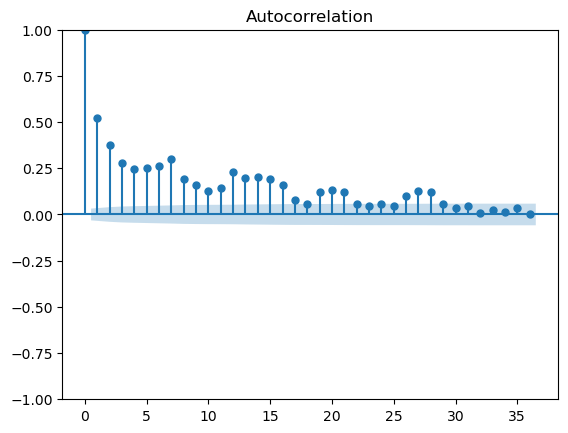

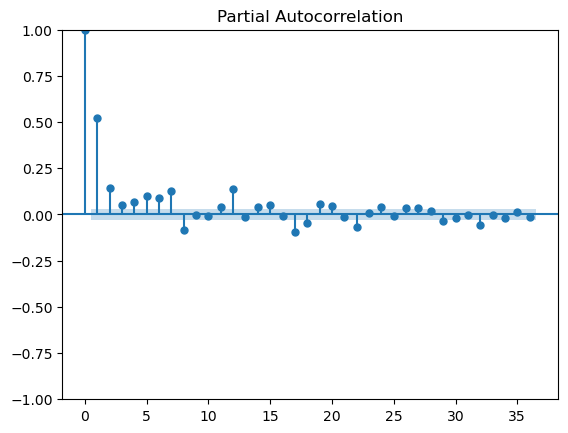

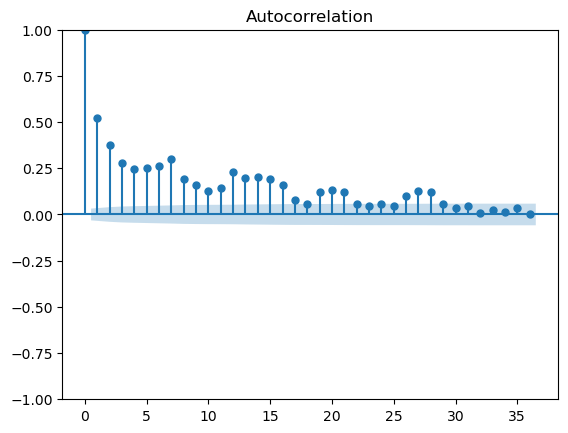

In [456]:
df_log = np.log(df["count"])
plot_pacf(df["count"])
plot_acf(df["count"])

In [457]:
df["rolling_mean_Level"].isna()

date
2013-09-02    False
2013-09-03    False
2013-09-04    False
2013-09-05    False
2013-09-06    False
              ...  
2023-12-27    False
2023-12-28    False
2023-12-29    False
2023-12-30    False
2023-12-31    False
Name: rolling_mean_Level, Length: 3772, dtype: bool

In [411]:
include_months = [4,5,6,7,8,9]
df = df[df["month"].isin(include_months)]
print(df.shape)

(1859, 19)


In [458]:
train = df[df["year"] < 2023]
test = df[df["year"] == 2023]
print(train.shape, test.shape)

(3407, 19) (365, 19)


In [459]:
print(df[df.index >= "2020-01-01"].shape[0])

1461


In [460]:
use_for_feats = df.iloc[:,7:20].columns.tolist()
use_for_feats

['november_Flow',
 'december_Temp',
 'january_Temp',
 'feburary_Temp',
 'october_Level',
 'november_Level',
 'rolling_mean_Temp',
 'rolling_std_Temp',
 'rolling_mean_Flow',
 'rolling_std_Flow',
 'rolling_mean_Level',
 'rolling_std_Level']

In [415]:
# forecaster = ForecasterAutoreg(
#                  regressor = RandomForestRegressor(random_state=123),
#                  lags = 10
#              )

# forecaster.fit(
#     y    = train['count'],
#     exog = train[use_for_feats]
# )

# forecaster

In [416]:
test

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
date,,,,,,,,,,,,,,,,,,,
2023-04-01,4,2023,4.512500,11.5500,1.0580,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.274028,1.853413,9.499333,3.111329,0.996083,0.071829
2023-04-02,4,2023,3.695833,10.5450,1.0335,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.298056,1.827066,9.663333,3.028638,1.000733,0.069470
2023-04-03,4,2023,2.666667,9.4100,1.0065,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291667,1.836203,9.763167,2.966598,1.003583,0.067820
2023-04-04,4,2023,3.916667,8.5600,0.9835,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291111,1.836631,9.820000,2.925003,1.005100,0.066804
2023-04-05,4,2023,3.887500,7.7500,0.9620,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291111,1.836631,9.856667,2.890587,1.006150,0.065831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,9,2023,13.229167,0.7195,0.5825,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.672917,2.119124,0.287667,0.109644,0.542167,0.011124
2023-09-27,9,2023,12.479167,1.2015,0.6060,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.410278,2.003509,0.320650,0.198734,0.544383,0.016091
2023-09-28,9,2023,12.450000,1.8365,0.6275,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.268889,2.058866,0.373283,0.340186,0.547117,0.022122


In [434]:
df["month"].unique()

array([9, 4, 5, 6, 7, 8])

<Axes: xlabel='date'>

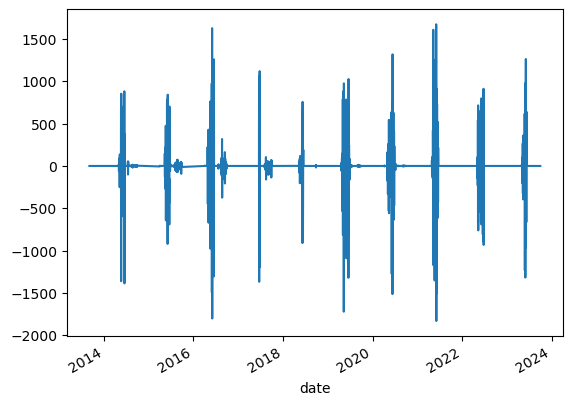

In [433]:
df["count"].diff().diff().plot()

In [418]:
# predictions = forecaster.predict(
#                   steps = 330,
#                   exog = test[use_for_feats]
#               )

# predictions.head(3)

In [461]:
def impute_for_missing(df):
      missing_cols = df.columns[df.isna().any()].tolist()
      for col in missing_cols:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
      return df

df2 = impute_for_missing(df)
df2

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
date,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,5.307917,2.217812,24.808667,26.852532,1.150467,0.320490
2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,5.535972,2.230511,25.657167,26.597649,1.166617,0.312316
2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,5.737222,2.203401,26.555333,26.310389,1.183850,0.302708


In [420]:
df["rolling_mean_Level"].isna().sum()

0

In [435]:
model = auto_arima(train['count'], 
                   exenous=train[use_for_feats], 
                   seasonal=True, 
                   m=12, 
                   verbose=True)
model

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [462]:
sar = SARIMAX(
      endog=df["count"],
      exog=df[use_for_feats],
      order=(2,1,1),
      seasonal_order=(0,0,1,12),
      trend="c"
)

# sar = SARIMAX(
#       endog=train["count"],
#       exog=train[use_for_feats],
#       order=(5,0,5),
#       seasonal_order=(0,0,2,12),
#       trend="c"
# )

results = sar.fit(disp=False)

/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [463]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                 3772
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 12)   Log Likelihood              -22473.621
Date:                            Sun, 09 Jun 2024   AIC                          44983.242
Time:                                    17:30:20   BIC                          45095.474
Sample:                                         0   HQIC                         45023.145
                                           - 3772                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             -0.0063      0.361     -0.017      0.986      -0.715       0.702
november_Flow         -0.0893     93.902     -0.001      0.999    -184.134     183.956
december_Temp          0.1815    343.624      0.001      1.000    -673.309     673.672
january_Temp           0.0428    621.758   6.88e-05      1.000   -1218.581    1218.666
feburary_Temp          0.5168    213.988      0.002      0.998    -418.891     419.925
october_Level          2.6305   4541.734      0.001      1.000   -8899.005    8904.267
november_Level         7.2973   7074.540      0.001      0.999   -1.39e+04    1.39e+04
rolling_mean_Temp     -2.2237      4.388     -0.507      0.612     -10.825       6.377
rolling_std_Temp      -8.0120      5.565     -1.440      0.150     -18.918       2.894
rolling_mean_Flow      2.1678      5.732      0.378      0.705      -9.066      13.402
rolling_std_Flow      -0.4022      6.161     -0.065      0.948     -12.477      11.672
rolling_mean_Level  -153.3608    228.476     -0.671      0.502    -601.166     294.445
rolling_std_Level     35.7662    376.297      0.095      0.924    -701.763     773.295
ar.L1                  0.3768      0.006     64.659      0.000       0.365       0.388
ar.L2                  0.0730      0.006     13.260      0.000       0.062       0.084
ma.L1                 -0.9414      0.003   -272.259      0.000      -0.948      -0.935
ma.S.L12               0.1108      0.005     23.897      0.000       0.102       0.120
sigma2              8671.3479     55.808    155.377      0.000    8561.965    8780.730
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            389978.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             4.06
Prob(H) (two-sided):                  0.04   Kurtosis:                        52.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [438]:
sar_test = test[use_for_feats].iloc[0:5,:]

In [439]:
df_subset

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
date,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-05,9,2013,16.837500,0.6945,0.5300,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
2013-09-06,9,2013,16.954167,0.6680,0.5280,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,9,2023,13.229167,0.7195,0.5825,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,15.672917,2.119124,0.287667,0.109644,0.542167,0.011124
2023-09-27,9,2023,12.479167,1.2015,0.6060,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,15.410278,2.003509,0.320650,0.198734,0.544383,0.016091
2023-09-28,9,2023,12.450000,1.8365,0.6275,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,15.268889,2.058866,0.373283,0.340186,0.547117,0.022122


In [464]:
results.predict(start=0, end=len(df)-1)

date
2013-09-02   -142.724954
2013-09-03     -0.589476
2013-09-04     -0.311608
2013-09-05     -0.253391
2013-09-06     -0.215838
                 ...    
2023-12-27     -1.778073
2023-12-28     -2.786077
2023-12-29     -3.138533
2023-12-30     -3.683496
2023-12-31     -3.923531
Name: predicted_mean, Length: 3772, dtype: float64

In [465]:
df["pred"] = results.predict(start=0, end=len(train)-1)
df

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred
date,,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-142.724954
2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.589476
2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.311608
2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.253391
2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,7.679129,28.382500,3.965188,4.324905,3.464881,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.215838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,5.307917,2.217812,24.808667,26.852532,1.150467,0.320490,NaN
2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,5.535972,2.230511,25.657167,26.597649,1.166617,0.312316,NaN
2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.015860,4.861828,3.270828,0.675435,0.829067,5.737222,2.203401,26.555333,26.310389,1.183850,0.302708,NaN


In [466]:
adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
df["pred_adjust"] = df.apply(adjust_val, axis=1)
df

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,...,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust
date,,,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,7.679129,28.382500,3.965188,4.324905,...,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-142.724954,0.0
2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,7.679129,28.382500,3.965188,4.324905,...,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.589476,0.0
2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,7.679129,28.382500,3.965188,4.324905,...,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.311608,0.0
2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,7.679129,28.382500,3.965188,4.324905,...,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.253391,0.0
2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,7.679129,28.382500,3.965188,4.324905,...,0.795806,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.215838,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.015860,4.861828,...,0.675435,0.829067,5.307917,2.217812,24.808667,26.852532,1.150467,0.320490,NaN,NaN
2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.015860,4.861828,...,0.675435,0.829067,5.535972,2.230511,25.657167,26.597649,1.166617,0.312316,NaN,NaN
2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.015860,4.861828,...,0.675435,0.829067,5.737222,2.203401,26.555333,26.310389,1.183850,0.302708,NaN,NaN


<Axes: xlabel='date'>

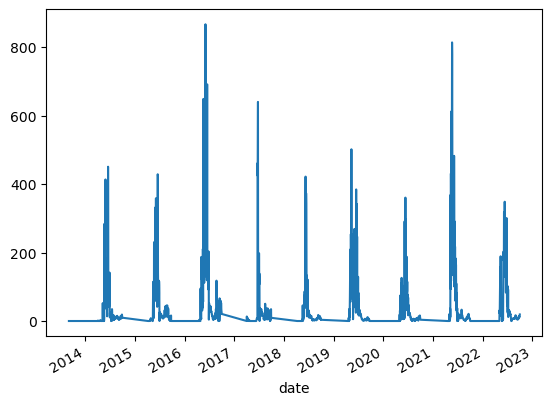

In [444]:
viz_df = train["pred_adjust"]
viz_df.plot()

In [467]:
def count_total_diff(df):
      df["diff"] = abs(df["pred_adjust"] - df["count"])
      total_diff = df["diff"].sum()
      total_matching_zeros = len(df[(df["count"] == 0) & (df["pred_adjust"] == 0)])
      return total_diff, total_matching_zeros

def evaluate_model(df):
      mae = mean_absolute_error(df['count'], df['pred_adjust'])
      mse = mean_squared_error(df['count'], df['pred_adjust'])
      rmse = np.sqrt(mse)
      return mae, mse, rmse

count_total_diff(df)
evaluate_model(df)

ValueError: Input contains NaN.

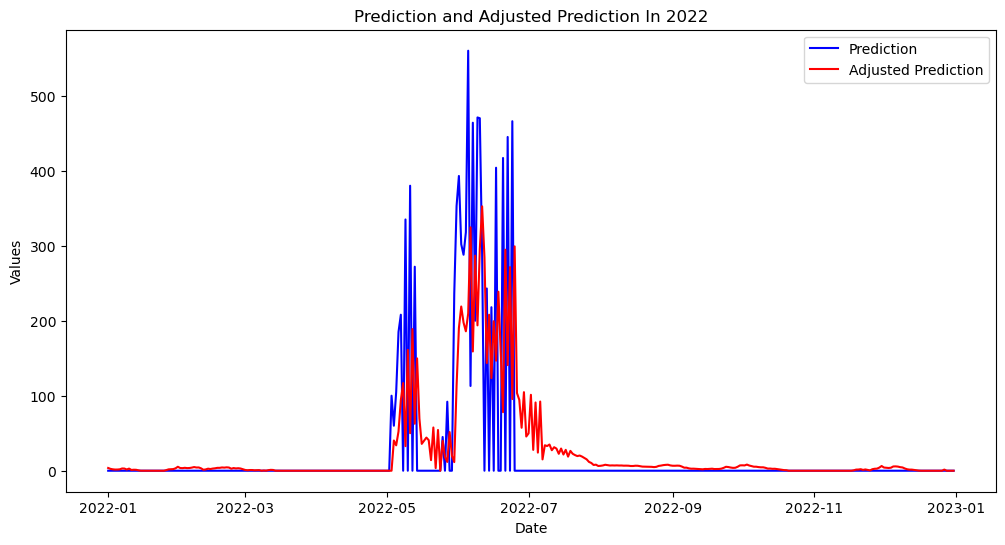

In [470]:
df_2022 = df[df["year"] == 2022]

plt.figure(figsize=(12, 6))
plt.plot(df_2022.index, df_2022['count'], label='Prediction', color='blue')
plt.plot(df_2022.index, df_2022['pred_adjust'], label='Adjusted Prediction', color='red')

# Adding title and labels
plt.title('Prediction and Adjusted Prediction In 2022')
plt.xlabel('Date')
plt.ylabel('Values')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [447]:
train.head(5)

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,...,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust,diff
date,,,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,4.324905,...,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,-602.761941,0.0,0.0
2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,4.324905,...,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,-5.004246,0.0,0.0
2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,4.324905,...,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,-2.816892,0.0,0.0
2013-09-05,9,2013,16.837500,0.6945,0.5300,0.0,7.679129,28.3825,3.965188,4.324905,...,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,-2.188467,0.0,0.0
2013-09-06,9,2013,16.954167,0.6680,0.5280,0.0,7.679129,28.3825,3.965188,4.324905,...,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,-1.784372,0.0,0.0


In [448]:
def find_date(df, real_count, observe_num=5, max_repeat=5):
    df = df.reset_index()
    repeat_count = 0
    real_date = "Not defined"

    for ind, row in df.iterrows():
        if ind == 0:
            continue
        
        print(f" Ind: {ind}, Date: {row['date']}, Count: {row[real_count]}")

        if (row[real_count] >= observe_num) & (df.loc[ind-1, real_count] >= observe_num):
            print(f"----------------------{repeat_count}-----------------------")
            repeat_count += 1
        else:
            repeat_count = 0

        if repeat_count == max_repeat:
            print(f"Stopping at: {ind}, Date: {row['date']}")
            real_date = df.loc[ind, "date"]
            break

    return real_date

real_date = find_date(df_2023, "pred_adjust", 5, 4)

 Ind: 1, Date: 2023-01-02 00:00:00, Count: 0.0
 Ind: 2, Date: 2023-01-03 00:00:00, Count: 0.0
 Ind: 3, Date: 2023-01-04 00:00:00, Count: 0.0
 Ind: 4, Date: 2023-01-05 00:00:00, Count: 0.0
 Ind: 5, Date: 2023-01-06 00:00:00, Count: 0.0
 Ind: 6, Date: 2023-01-07 00:00:00, Count: 0.0
 Ind: 7, Date: 2023-01-08 00:00:00, Count: 0.0
 Ind: 8, Date: 2023-01-09 00:00:00, Count: 0.0
 Ind: 9, Date: 2023-01-10 00:00:00, Count: 0.0
 Ind: 10, Date: 2023-01-11 00:00:00, Count: 0.0
 Ind: 11, Date: 2023-01-12 00:00:00, Count: 0.0
 Ind: 12, Date: 2023-01-13 00:00:00, Count: 0.0
 Ind: 13, Date: 2023-01-14 00:00:00, Count: 0.0
 Ind: 14, Date: 2023-01-15 00:00:00, Count: 0.0
 Ind: 15, Date: 2023-01-16 00:00:00, Count: 0.0
 Ind: 16, Date: 2023-01-17 00:00:00, Count: 0.0
 Ind: 17, Date: 2023-01-18 00:00:00, Count: 0.0
 Ind: 18, Date: 2023-01-19 00:00:00, Count: 0.0
 Ind: 19, Date: 2023-01-20 00:00:00, Count: 0.0
 Ind: 20, Date: 2023-01-21 00:00:00, Count: 8.0
 Ind: 21, Date: 2023-01-22 00:00:00, Count: 8.0
-

In [326]:
for year in df["year"].unique().tolist():
      df_year = df[df["year"] == year]
      quantile_10 = df_year["count"].quantile(0.9)
      print(quantile_10)

0.0
3.0
10.400000000000091
43.0
0.0
0.0
10.600000000000023
3.0
0.0
0.0
0.0


In [327]:
find_date(df_2023, "count", 5, 2)

 Ind: 1, Date: 2023-01-02 00:00:00, Count: 0.0
 Ind: 2, Date: 2023-01-03 00:00:00, Count: 0.0
 Ind: 3, Date: 2023-01-04 00:00:00, Count: 0.0
 Ind: 4, Date: 2023-01-05 00:00:00, Count: 0.0
 Ind: 5, Date: 2023-01-06 00:00:00, Count: 0.0
 Ind: 6, Date: 2023-01-07 00:00:00, Count: 0.0
 Ind: 7, Date: 2023-01-08 00:00:00, Count: 0.0
 Ind: 8, Date: 2023-01-09 00:00:00, Count: 0.0
 Ind: 9, Date: 2023-01-10 00:00:00, Count: 0.0
 Ind: 10, Date: 2023-01-11 00:00:00, Count: 0.0
 Ind: 11, Date: 2023-01-12 00:00:00, Count: 0.0
 Ind: 12, Date: 2023-01-13 00:00:00, Count: 0.0
 Ind: 13, Date: 2023-01-14 00:00:00, Count: 0.0
 Ind: 14, Date: 2023-01-15 00:00:00, Count: 0.0
 Ind: 15, Date: 2023-01-16 00:00:00, Count: 0.0
 Ind: 16, Date: 2023-01-17 00:00:00, Count: 0.0
 Ind: 17, Date: 2023-01-18 00:00:00, Count: 0.0
 Ind: 18, Date: 2023-01-19 00:00:00, Count: 0.0
 Ind: 19, Date: 2023-01-20 00:00:00, Count: 0.0
 Ind: 20, Date: 2023-01-21 00:00:00, Count: 0.0
 Ind: 21, Date: 2023-01-22 00:00:00, Count: 0.0
 

Timestamp('2023-06-01 00:00:00')

In [474]:
df

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,...,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust,diff
date,,,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,7.679129,28.382500,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-142.724954,0.0,0.0
2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,7.679129,28.382500,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.589476,0.0,0.0
2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,7.679129,28.382500,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.311608,0.0,0.0
2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,7.679129,28.382500,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.253391,0.0,0.0
2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,7.679129,28.382500,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.215838,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.015860,4.861828,...,0.829067,5.307917,2.217812,24.808667,26.852532,1.150467,0.320490,NaN,NaN,NaN
2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.015860,4.861828,...,0.829067,5.535972,2.230511,25.657167,26.597649,1.166617,0.312316,NaN,NaN,NaN
2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.015860,4.861828,...,0.829067,5.737222,2.203401,26.555333,26.310389,1.183850,0.302708,NaN,NaN,NaN


In [475]:
def find_date_simple(df, count_col="count", detect_num=10):
      df = df.reset_index()
      for ind, row in df.iterrows():
            if df[count_col].max() <= detect_num:
                  print(f"No value available.")
                  break
            if row[count_col] >= detect_num:
                  date = row["date"]
                  return date

find_date_simple(df_2022)

Timestamp('2022-05-03 00:00:00')

In [477]:
for year in df["year"].unique().tolist():
      df_year = df[df["year"] == year]
      df_year = df_year.reset_index()
      print(f"-----------------Year {year}-------------------")
      print(f"Actual Start Date: {find_date_simple(df_year, 'count', 10)}")
      print(f"Predicted Start Date: {find_date_simple(df_year, 'pred_adjust', 10)}")

-----------------Year 2013-------------------
No value available.
Actual Start Date: None
Predicted Start Date: 2013-10-01 00:00:00
-----------------Year 2014-------------------
Actual Start Date: 2014-05-02 00:00:00
Predicted Start Date: 2014-05-03 00:00:00
-----------------Year 2015-------------------
Actual Start Date: 2015-05-12 00:00:00
Predicted Start Date: 2015-05-13 00:00:00
-----------------Year 2016-------------------
Actual Start Date: 2016-04-26 00:00:00
Predicted Start Date: 2016-04-27 00:00:00
-----------------Year 2017-------------------
Actual Start Date: 2017-06-19 00:00:00
Predicted Start Date: 2017-06-20 00:00:00
-----------------Year 2018-------------------
Actual Start Date: 2018-05-14 00:00:00
Predicted Start Date: 2018-05-15 00:00:00
-----------------Year 2019-------------------
Actual Start Date: 2019-01-21 00:00:00
Predicted Start Date: 2019-02-22 00:00:00
-----------------Year 2020-------------------
Actual Start Date: 2020-01-09 00:00:00
Predicted Start Date:

In [427]:
test

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
date,,,,,,,,,,,,,,,,,,,
2023-04-01,4,2023,4.512500,11.5500,1.0580,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.274028,1.853413,9.499333,3.111329,0.996083,0.071829
2023-04-02,4,2023,3.695833,10.5450,1.0335,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.298056,1.827066,9.663333,3.028638,1.000733,0.069470
2023-04-03,4,2023,2.666667,9.4100,1.0065,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291667,1.836203,9.763167,2.966598,1.003583,0.067820
2023-04-04,4,2023,3.916667,8.5600,0.9835,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291111,1.836631,9.820000,2.925003,1.005100,0.066804
2023-04-05,4,2023,3.887500,7.7500,0.9620,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291111,1.836631,9.856667,2.890587,1.006150,0.065831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,9,2023,13.229167,0.7195,0.5825,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.672917,2.119124,0.287667,0.109644,0.542167,0.011124
2023-09-27,9,2023,12.479167,1.2015,0.6060,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.410278,2.003509,0.320650,0.198734,0.544383,0.016091
2023-09-28,9,2023,12.450000,1.8365,0.6275,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.268889,2.058866,0.373283,0.340186,0.547117,0.022122


In [450]:
forecast_steps = 183  # Adjust this according to how many steps ahead you want to forecast
forecast = results.forecast(steps=forecast_steps, exog=test[use_for_feats])
forecast_list = forecast.tolist()
forecast_list

/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[-98.72760886434651,
 -94.7437531010977,
 -93.2253372396566,
 -92.69991827136698,
 -92.98337615218486,
 -94.87614741698951,
 -100.56908593525804,
 -102.75565638068622,
 -112.72823221516751,
 -107.94808992929893,
 -107.56417158866122,
 -108.30179410167977,
 -106.79652694422009,
 -105.90387611113113,
 -105.78695225855597,
 -106.17829905891904,
 -105.54214208270548,
 -104.5406285844225,
 -102.66831130673143,
 -101.53868816060913,
 -101.32320580680164,
 -100.97000451394047,
 -101.49459542929367,
 -100.26228286919218,
 -99.70564614182365,
 -102.74970332743624,
 -105.00489321949442,
 -109.59286675407759,
 -119.66775188271356,
 -127.49950408632117,
 -129.75144808282096,
 -132.75092393670627,
 -139.85209156222516,
 -144.06596301066963,
 -142.7016340664012,
 -142.0788947491816,
 -141.52272097749562,
 -142.10737060503948,
 -139.46073572473279,
 -135.74747717495256,
 -137.4145881528193,
 -139.2699532479396,
 -143.84542196082305,
 -149.23503783089984,
 -156.9743856708992,
 -161.65302938946445,
 -1

In [430]:
test["pred"] = forecast_list
test

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_6694/3597401935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred"] = forecast_list


,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred
date,,,,,,,,,,,,,,,,,,,,
2023-04-01,4,2023,4.512500,11.5500,1.0580,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.274028,1.853413,9.499333,3.111329,0.996083,0.071829,-118.715111
2023-04-02,4,2023,3.695833,10.5450,1.0335,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.298056,1.827066,9.663333,3.028638,1.000733,0.069470,-114.025015
2023-04-03,4,2023,2.666667,9.4100,1.0065,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291667,1.836203,9.763167,2.966598,1.003583,0.067820,-112.645155
2023-04-04,4,2023,3.916667,8.5600,0.9835,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291111,1.836631,9.820000,2.925003,1.005100,0.066804,-112.115355
2023-04-05,4,2023,3.887500,7.7500,0.9620,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.291111,1.836631,9.856667,2.890587,1.006150,0.065831,-112.286329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,9,2023,13.229167,0.7195,0.5825,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.672917,2.119124,0.287667,0.109644,0.542167,0.011124,-54.007162
2023-09-27,9,2023,12.479167,1.2015,0.6060,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.410278,2.003509,0.320650,0.198734,0.544383,0.016091,-49.356440
2023-09-28,9,2023,12.450000,1.8365,0.6275,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,15.268889,2.058866,0.373283,0.340186,0.547117,0.022122,-48.881566


In [480]:
def find_peak_dates(df, column):
      df = df.reset_index()
      year_record = {}

      for year in df["year"].unique().tolist():
            df_year = df[df["year"] == year]
            max_num_ind = df_year[column].idxmax()
            year_record[str(df.loc[max_num_ind, "date"])] = df.loc[max_num_ind, column]
      return year_record

find_peak_dates(df, "count")

{'2013-09-02 00:00:00': 0.0,
 '2014-06-16 00:00:00': 881.0,
 '2015-06-16 00:00:00': 713.0,
 '2016-06-01 00:00:00': 1672.0,
 '2017-06-22 00:00:00': 1119.0,
 '2018-06-07 00:00:00': 756.0,
 '2019-05-10 00:00:00': 975.0,
 '2020-06-10 00:00:00': 756.0,
 '2021-05-20 00:00:00': 1247.0,
 '2022-06-05 00:00:00': 560.0,
 '2023-05-30 00:00:00': 976.0}

In [481]:
year_dict = find_peak_dates(df, "pred_adjust")
year_dict

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_6694/1134270277.py:7: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_num_ind = df_year[column].idxmax()


KeyError: nan

In [483]:
df.dropna(subset=["pred_adjust"])

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,...,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust,diff
date,,,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-142.724954,0.000000,0.000000
2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.589476,0.000000,0.000000
2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.311608,0.000000,0.000000
2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.253391,0.000000,0.000000
2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.215838,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,12,2022,6.337500,174.500000,2.7365,0.0,23.103871,66.4550,1.127608,2.843952,...,1.681733,0.357083,3.486503,22.497167,46.604569,1.077833,0.512663,1.551895,1.551895,1.551895
2022-12-28,12,2022,6.458333,86.250000,2.0680,0.0,23.103871,66.4550,1.127608,2.843952,...,1.681733,0.527361,3.657231,25.116500,47.931827,1.114250,0.543046,-0.710342,0.000000,0.000000
2022-12-29,12,2022,4.145833,43.699999,1.6175,0.0,23.103871,66.4550,1.127608,2.843952,...,1.681733,0.710694,3.697295,26.367167,47.910179,1.137600,0.549296,-1.820656,0.000000,0.000000


In [485]:
df_no_2022 = df[df["year"] <= 2022]
df_no_2022

,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,...,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust,diff
date,,,,,,,,,,,,,,,,,,,,,
2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-142.724954,0.000000,0.000000
2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.589476,0.000000,0.000000
2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.311608,0.000000,0.000000
2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.253391,0.000000,0.000000
2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,7.679129,28.3825,3.965188,4.324905,...,1.166450,9.514444,2.539781,8.101333,3.857294,0.858400,0.102316,-0.215838,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,12,2022,6.337500,174.500000,2.7365,0.0,23.103871,66.4550,1.127608,2.843952,...,1.681733,0.357083,3.486503,22.497167,46.604569,1.077833,0.512663,1.551895,1.551895,1.551895
2022-12-28,12,2022,6.458333,86.250000,2.0680,0.0,23.103871,66.4550,1.127608,2.843952,...,1.681733,0.527361,3.657231,25.116500,47.931827,1.114250,0.543046,-0.710342,0.000000,0.000000
2022-12-29,12,2022,4.145833,43.699999,1.6175,0.0,23.103871,66.4550,1.127608,2.843952,...,1.681733,0.710694,3.697295,26.367167,47.910179,1.137600,0.549296,-1.820656,0.000000,0.000000


In [512]:
actual_peak = find_peak_dates(df_no_2022, "count")
pred_peak = find_peak_dates(df_no_2022, "pred_adjust")

In [513]:
actual_peak = pd.DataFrame(actual_peak, index=[0]).T
pred_peak = pd.DataFrame(pred_peak, index=[0]).T

In [515]:
display(pred_peak)

,0
2013-10-01 00:00:00,12.281468
2014-06-17 00:00:00,444.932550
2015-06-17 00:00:00,435.784225
2016-06-02 00:00:00,857.726580
2017-06-23 00:00:00,648.722881
2018-06-08 00:00:00,423.884286
2019-05-11 00:00:00,508.202240
2020-06-11 00:00:00,354.944758
2021-05-20 00:00:00,807.483809
2022-06-11 00:00:00,352.452681


/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_6694/2561461406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_adjust"] = test.apply(adjust_val, axis=1)


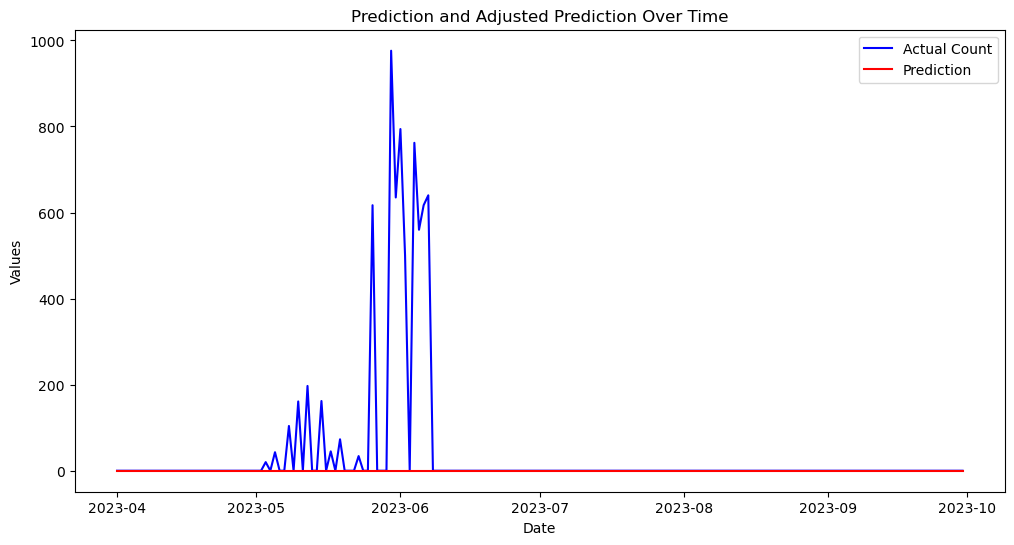

In [449]:
adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
test["pred_adjust"] = test.apply(adjust_val, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['count'], label='Actual Count', color='blue')
plt.plot(test.index, test['pred_adjust'], label='Prediction', color='red')

# Adding title and labels
plt.title('Prediction and Adjusted Prediction Over Time')
plt.xlabel('Date')
plt.ylabel('Values')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [231]:
pred_date = find_date(df_2023, "pred_adjust", 3, 5)
pred_date

 Ind: 1, Count: 0.0
 Ind: 2, Count: 0.0
 Ind: 3, Count: 0.0
 Ind: 4, Count: 0.0
 Ind: 5, Count: 0.0
 Ind: 6, Count: 0.0
 Ind: 7, Count: 0.0
 Ind: 8, Count: 0.0
 Ind: 9, Count: 0.0
 Ind: 10, Count: 0.0
 Ind: 11, Count: 0.0
 Ind: 12, Count: 0.0
 Ind: 13, Count: 0.0
 Ind: 14, Count: 0.0
 Ind: 15, Count: 0.0
 Ind: 16, Count: 0.0
 Ind: 17, Count: 0.0
 Ind: 18, Count: 0.0
 Ind: 19, Count: 0.0
 Ind: 20, Count: 0.0
 Ind: 21, Count: 0.0
 Ind: 22, Count: 0.0
 Ind: 23, Count: 0.0
 Ind: 24, Count: 0.0
 Ind: 25, Count: 0.0
 Ind: 26, Count: 0.0
 Ind: 27, Count: 0.0
 Ind: 28, Count: 0.0
 Ind: 29, Count: 0.0
 Ind: 30, Count: 0.0
 Ind: 31, Count: 0.0
 Ind: 32, Count: 0.0
 Ind: 33, Count: 0.0
 Ind: 34, Count: 0.0
 Ind: 35, Count: 0.0
 Ind: 36, Count: 0.0
 Ind: 37, Count: 0.0
 Ind: 38, Count: 0.0
 Ind: 39, Count: 0.0
 Ind: 40, Count: 0.0
 Ind: 41, Count: 0.0
 Ind: 42, Count: 0.0
 Ind: 43, Count: 0.0
 Ind: 44, Count: 0.0
 Ind: 45, Count: 0.0
 Ind: 46, Count: 0.0
 Ind: 47, Count: 0.0
 Ind: 48, Count: 0.0
 

Timestamp('2023-05-15 00:00:00')